In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import time
import datetime

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Подход 1: градиентный бустинг "в лоб"

### 1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке)

In [58]:
features = pd.read_csv('./features.csv', index_col='match_id')

features.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'
        ], axis=1, inplace=True)

### 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [59]:
rows = len(features)

counts = features.describe().T['count']
na = counts[counts < rows]
na.apply(lambda l: 1 - l/rows).sort_values()


dire_courier_time              0.006953
radiant_courier_time           0.007117
dire_first_ward_time           0.018780
radiant_first_ward_time        0.018883
radiant_bottle_time            0.161380
dire_bottle_time               0.166029
first_blood_time               0.201100
first_blood_team               0.201100
first_blood_player1            0.201100
dire_flying_courier_time       0.268415
radiant_flying_courier_time    0.282619
first_blood_player2            0.452402
Name: count, dtype: float64

### 3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [60]:
features = features.fillna(0)

### 4. Какой столбец содержит целевую переменную? Запишите его название.

radiant_win

### 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [61]:
X_train = features
y_train = features['radiant_win'].values.ravel()
del features['radiant_win']

In [62]:
cv = KFold(n_splits = 5, shuffle=True)

In [63]:
scores = []
tree_numbers = [10, 20, 30, 40, 50]
for k in tree_numbers:
    model = GradientBoostingClassifier(n_estimators=k)
    
    start_time = datetime.datetime.now()
    current_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    
    print ('Tree number:' + str(k) + ' Time elapsed:      ' + str(datetime.datetime.now() - start_time))
    scores.append(np.mean(current_scores))

Tree number:10 Time elapsed:      0:00:31.010271
Tree number:20 Time elapsed:      0:00:56.817065
Tree number:30 Time elapsed:      0:01:22.898167
Tree number:40 Time elapsed:      0:01:49.180021
Tree number:50 Time elapsed:      0:02:16.999313


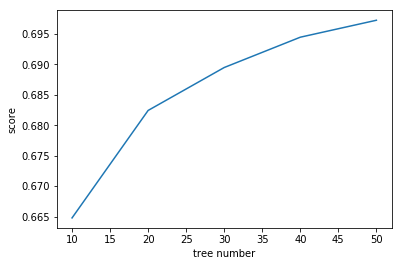

In [64]:
plt.plot(tree_numbers, scores)
plt.xlabel('tree number')
plt.ylabel('score')
plt.show()

In [65]:
scores[2]

0.6894703037774905

## Отчет

### 1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

dire_courier_time - команда не приобретает предмет "courier" за первые 5 минут игры в 0.6% случаев  
radiant_courier_time - команда не приобретает предмет "courier" за первые 5 минут игры в 0.7% случаев   
dire_first_ward_time - команда не ставит наблюдателя за первые 5 минут игры в 1.8% случаев  
radiant_first_ward_time - команда не ставит наблюдателя за первые 5 минут игры в 1.8% случаев  
radiant_bottle_time  
dire_bottle_time  
first_blood_time  
first_blood_team  
first_blood_player1  
dire_flying_courier_time  
radiant_flying_courier_time  
first_blood_player2

### 2. Как называется столбец, содержащий целевую переменную?

radiant_win

### 3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.

Время проведения кросс-валидации для градиентного бустинга с 30 деревьями: 0:01:22.  Полученное качество при таком количестве деревьев - 0.69.

### 4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Использование больше 30 деревьев целесообразно, так как качество улучшается. Чтобы ускорить обучение можно брать не всю обучающую выборку, а какую-то ее часть, а также установить максимальную глубину деревьев.

# Подход 2: логистическая регрессия

### 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [66]:
cv = KFold(n_splits = 5, shuffle=True)

X_train = StandardScaler().fit_transform(X_train)

In [67]:
scores = []
pows = range(-3, 5)
c_values = [10.0 ** i for i in pows]
for c in c_values:
    start_time = datetime.datetime.now()
    model = LogisticRegression(C=c, random_state=42)
    current_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    print ('c :' + str(c) + ' Time elapsed:      ' + str(datetime.datetime.now() - start_time), current_scores)
    scores.append(np.mean(current_scores))

c :0.001 Time elapsed:      0:00:09.564734 [0.71526347 0.71313629 0.71698531 0.71838471 0.71815338]
c :0.01 Time elapsed:      0:00:12.638360 [0.71203522 0.71281819 0.72186315 0.71912143 0.71631409]
c :0.1 Time elapsed:      0:00:12.799519 [0.71357528 0.71857782 0.71374692 0.71745568 0.7190061 ]
c :1.0 Time elapsed:      0:00:13.383352 [0.71125082 0.72173554 0.71513922 0.71695407 0.71679614]
c :10.0 Time elapsed:      0:00:13.634857 [0.71589426 0.72474353 0.71386781 0.71489851 0.71326035]
c :100.0 Time elapsed:      0:00:13.555687 [0.71654332 0.70682698 0.71567947 0.72146657 0.7210402 ]
c :1000.0 Time elapsed:      0:00:13.522655 [0.71548196 0.71265383 0.71964735 0.71360558 0.72027398]
c :10000.0 Time elapsed:      0:00:13.343057 [0.71785154 0.71424109 0.71741546 0.71615366 0.71637867]


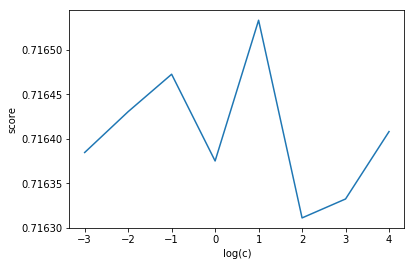

Scores: [0.7163846320341405, 0.7164304175536932, 0.7164723602251755, 0.71637515729087, 0.7165328931824468, 0.7163113086456058, 0.716332537564233, 0.7164080836571249] max: 0.7165328931824468
Best C is  10.0


In [68]:
plt.plot(pows, scores)
plt.xlabel('log(c)')
plt.ylabel('score')
plt.show()
max_score = max(scores)
print('Scores:', scores , 'max:', max_score)
print('Best C is ', c_values[scores.index(max_score)])

### 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [69]:
features.drop(['lobby_type',
    'r1_hero',
    'r2_hero',
    'r3_hero',
    'r4_hero',
    'r5_hero',
    'd1_hero',
    'd2_hero',
    'd3_hero',
    'd4_hero',
    'd5_hero'],axis = 1, inplace = True)

X_train = StandardScaler().fit_transform(features)

scores = []
for c in c_values:
    start_time = datetime.datetime.now()
    model = LogisticRegression(C=c, random_state=42)
    current_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    print ('c :' + str(c) + ' Time elapsed:      ' + str(datetime.datetime.now() - start_time), current_scores)
    scores.append(np.mean(current_scores))

c :0.001 Time elapsed:      0:00:08.803515 [0.71905802 0.7167346  0.71645914 0.71245978 0.71569542]
c :0.01 Time elapsed:      0:00:11.480586 [0.71774266 0.71581632 0.71645069 0.71714734 0.71548455]
c :0.1 Time elapsed:      0:00:12.308379 [0.71717735 0.71516511 0.71489503 0.72060608 0.71316895]
c :1.0 Time elapsed:      0:00:12.590885 [0.71688452 0.72202665 0.7182141  0.71358778 0.7119536 ]
c :10.0 Time elapsed:      0:00:12.523479 [0.71659496 0.71472735 0.71248923 0.71698468 0.72134228]
c :100.0 Time elapsed:      0:00:12.056615 [0.71915106 0.72046835 0.71899826 0.71222161 0.7118643 ]
c :1000.0 Time elapsed:      0:00:12.482895 [0.71840258 0.71408324 0.71752518 0.71362473 0.7181471 ]
c :10000.0 Time elapsed:      0:00:12.437650 [0.71801424 0.70920238 0.71802094 0.72220568 0.71540825]


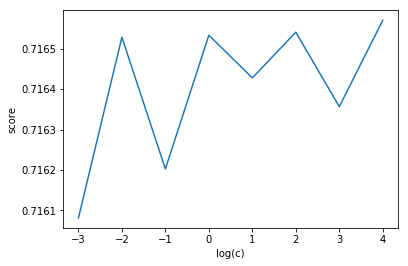

Scores: [0.7160813897187912, 0.7165283104415716, 0.7162025040940305, 0.7165333305208247, 0.716427701334877, 0.7165407154172065, 0.7163565654610213, 0.716570299528914] max: 0.716570299528914
Best C is  10000.0


In [70]:
plt.plot(pows, scores)
plt.xlabel('log(c)')
plt.ylabel('score')
plt.show()
max_score = max(scores)
print('Scores:', scores , 'max:', max_score)
print('Best C is ', c_values[scores.index(max_score)])

### 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [71]:
heroes = pd.read_csv('./features.csv', index_col='match_id')

heroes.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'
        ], axis=1, inplace=True)
heroes = heroes.fillna(0)

l = ['r' + str(i) + '_hero' for i in range(1,6)]
l += ['d' + str(i) + '_hero' for i in range(1,6)]
len(np.unique(heroes[l].values))


108

### 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [72]:
features = pd.read_csv('./features.csv', index_col='match_id')

features.drop(['duration', 
         'tower_status_radiant', 
         'tower_status_dire', 
         'barracks_status_radiant', 
         'barracks_status_dire'
        ], axis=1, inplace=True)

features = features.fillna(0)
del features['radiant_win']

X_pick = np.zeros((features.shape[0], 112))

for i, match_id in enumerate(features.index):
    for p in range(5):
        X_pick[i, features.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, features.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
l += ['lobby_type']
features.drop(l,axis = 1, inplace = True)

X_train = np.hstack((features.values, X_pick))

X_train = StandardScaler().fit_transform(X_train)

### 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [73]:
scores = []
for c in c_values:
    start_time = datetime.datetime.now()
    model = LogisticRegression(C=c, random_state=42)
    current_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    print ('c :' + str(c) + ' Time elapsed:      ' + str(datetime.datetime.now() - start_time), current_scores)
    scores.append(np.mean(current_scores))

c :0.001 Time elapsed:      0:00:15.268899 [0.75066749 0.75446907 0.75186921 0.75328392 0.74870705]
c :0.01 Time elapsed:      0:00:20.880925 [0.75460467 0.7563389  0.74283229 0.75696486 0.74815412]
c :0.1 Time elapsed:      0:00:22.426084 [0.75103822 0.74831164 0.75145866 0.75227271 0.75601417]
c :1.0 Time elapsed:      0:00:24.447592 [0.75773992 0.75024109 0.746453   0.75153402 0.75302784]
c :10.0 Time elapsed:      0:00:22.572278 [0.75202616 0.75084395 0.75624092 0.75294311 0.74585489]
c :100.0 Time elapsed:      0:00:22.690311 [0.75647142 0.75336675 0.74447303 0.75465195 0.75025072]
c :1000.0 Time elapsed:      0:00:21.800370 [0.7517942  0.75149462 0.75667674 0.74984171 0.74840655]
c :10000.0 Time elapsed:      0:00:22.671136 [0.74792492 0.75487542 0.7505294  0.75532817 0.7500739 ]


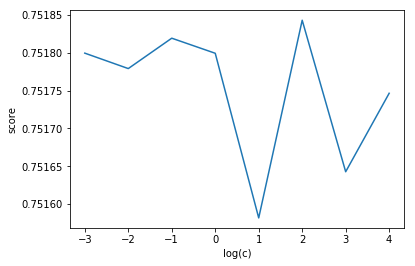

Scores: [0.7517993469864876, 0.7517789695635642, 0.751819077795546, 0.751799174677137, 0.7515818077353458, 0.7518427766219702, 0.7516427644203574, 0.7517463626753396] max: 0.7518427766219702
Best C is  100.0


In [74]:
plt.plot(pows, scores)
plt.xlabel('log(c)')
plt.ylabel('score')
plt.show()
max_score = max(scores)
print('Scores:', scores , 'max:', max_score)
print('Best C is ', c_values[scores.index(max_score)])

### 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [75]:
data = pd.read_csv('./features_test.csv',index_col='match_id')
data.fillna(0,inplace = True)


X_pick = np.zeros((data.shape[0], 112))

for i, match_id in enumerate(data.index):
    for p in range(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
        
data.drop([
    'lobby_type',
    'r1_hero',
    'r2_hero',
    'r3_hero',
    'r4_hero',
    'r5_hero',
    'd1_hero',
    'd2_hero',
    'd3_hero',
    'd4_hero',
    'd5_hero',
],axis = 1, inplace = True)

X_test = np.hstack((data.values, X_pick))
X_test = StandardScaler().fit_transform(X_test)

In [76]:
model = LogisticRegression(C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [77]:
scores = model.predict_proba(X_test)
scores = [scores[i][1] for i in range(len(scores))]

print('max:', max(scores))
print('min:', min(scores))

max: 0.9964712543352054
min: 0.008688602959339875


## Отчет

### 1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Наилучшее полученное качество модели 0.7165328931824468, что выше значений, полученных при использовании градиентного бустинга. Чтобы получить более высокое качество, необходимо обучить больше деревьев, что будет долго, а логистическая регрессия работает намного быстрее градиентного бустинга и дает лучшие оценки.

### 2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

Новое значение метрики качества 0.716570299528914 выше, чем было без удаления категориальных признаков. Это говорит о том, что категориальные признаки вносили некоторый шум, что осложняло процесс обучения, из-за чего качество было ниже.

### 3. Сколько различных идентификаторов героев существует в данной игре?

108

### 4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

0.7518427766219702, качество улучшилось. Это произошло из-за того, что признаки стали не категориальными, т.е. представление стало более удобным для проведения вычислении, что привело к повышению качества.

### 5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

max: 0.9964712543352054  
min: 0.008688602959339875